In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Установка seed для стандартного генератора случайных чисел Python
random.seed(42)

# Установка seed для NumPy (если используете его)
np.random.seed(42)

# Установка seed для PyTorch
torch.manual_seed(42)

# Если используете CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # Если у вас несколько GPU

# Для обеспечения полной повторяемости (этот шаг замедляет выполнение на GPU)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Common functions

Fedor data

In [3]:
# Data
subj_path = "..\\data\\Fedor\\preproc_angles\\1\\"
fs = 500


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    # h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    # data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    # data_test = data[l_idx:h_idx, :]
    data_train = data[:l_idx, :]
    data_test = data[l_idx:, :]

    return data_train, data_test


N_files = 4
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1597, 6, 256), (176, 6, 256), (1597, 20), (176, 20))

Aleksandr Data

In [2]:
subj_path = "..\\data\\Alexander Chevcov\\Simple(6 electrodes)\\Preprocessed\\Simple2\\"
fs = 500
n_channels = 6


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    # h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    # data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    # data_test = data[l_idx:h_idx, :]
    data_train = data[:l_idx, :]
    data_test = data[l_idx:, :]

    return data_train, data_test


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 8

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs, windowlen=256, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=256, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2844, 6, 128), (710, 6, 128), (2844, 20), (710, 20))

Nastya Data

In [ ]:
subj_path = "..\\data\\Alexander Chevcov\\Simple(6 electrodes)\\Preprocessed\\Simple2\\"
fs = 500
n_channels = 6

## Riemann Regression

### Covariances Matrix

In [ ]:
np.random.seed(42)
X = np.random.randn(10, 6, 1000)

# Применим ковариацию с OAS
cov_estimator = Covariances(estimator="oas")
cov_matrices = cov_estimator.fit_transform(X)

print(cov_matrices.shape)  # (10, 6, 6)
print(cov_matrices[0])


def oas_covariance(X):
    """OAS shrinkage covariance estimation for a single (channels x samples) matrix"""
    X = X - X.mean(axis=1, keepdims=True)  # центрируем по каналам
    n_channels, n_samples = X.shape

    # Стандартная ковариация
    sample_cov = (X @ X.T) / (n_samples - 1)

    # След и его квадрат
    trace_S = np.trace(sample_cov)
    trace_S2 = np.sum(sample_cov**2)

    # Оценка "alpha" для shrinkage
    shrinkage = min(
        1.0,
        ((1 - 2 / n_channels) * trace_S2 + trace_S**2)
        / ((n_samples + 1 - 2 / n_channels) * (trace_S2 - (trace_S**2) / n_channels)),
    )

    print(shrinkage)
    # Shrink к матрице I * (trace / n_channels)
    mu = trace_S / n_channels
    shrunk_cov = (1 - shrinkage) * sample_cov + shrinkage * mu * np.eye(n_channels)
    return shrunk_cov


def compute_covariances_oas(X):
    """X: shape (n_trials, n_channels, n_times)"""
    return np.array([oas_covariance(trial) for trial in X])


cov1 = Covariances(estimator="oas").fit_transform(X)

# Используем свою реализацию
cov2 = compute_covariances_oas(X)

# Проверим разницу
print("Equal:")
print(np.allclose(cov1, cov2))

print("Cov Matrices:")
print(cov1[0], cov2[0])

In [ ]:
# Симуляция данных: 10 эпох, 6 каналов, 1000 отсчётов времени
np.random.seed(42)
X = np.random.randn(10, 6, 1000)

# Расчёт ковариационных матриц с использованием OAS
cov_estimator = Covariances(estimator="oas")
cov_matrices = cov_estimator.fit_transform(X)

# Выбираем первую ковариационную матрицу для визуализации
cov_matrix = cov_matrices[0]

# Создаём тепловую карту
plt.figure(figsize=(6, 5))
plt.imshow(cov_matrix, cmap="viridis", interpolation="none")
plt.title("Ковариационная матрица (OAS) для первой эпохи")
plt.colorbar(label="Значение ковариации")
plt.xlabel("Каналы")
plt.ylabel("Каналы")
plt.xticks(range(cov_matrix.shape[0]))
plt.yticks(range(cov_matrix.shape[1]))
plt.show()

In [ ]:
cov_estimator = Covariances(estimator="oas").fit(X_train)
cov1 = cov_estimator.transform(X_train)
cov_matrix = cov1[5]

plt.figure(figsize=(6, 5))
plt.imshow(cov_matrix, cmap="viridis", interpolation="none")
plt.title("Ковариационная матрица (OAS) для первой эпохи")
plt.colorbar(label="Значение ковариации")
plt.xlabel("Каналы")
plt.ylabel("Каналы")
plt.xticks(range(cov_matrix.shape[0]))
plt.yticks(range(cov_matrix.shape[1]))
plt.show()

In [ ]:
cov_estimator = Covariances(estimator="oas").fit(X_train_emg)
cov1 = cov_estimator.transform(X_train_emg)
cov_matrix = cov1[0]

plt.figure(figsize=(6, 5))
plt.imshow(cov_matrix, cmap="viridis", interpolation="none")
plt.title("Ковариационная матрица (OAS) для первой эпохи")
plt.colorbar(label="Значение ковариации")
plt.xlabel("Каналы")
plt.ylabel("Каналы")
plt.xticks(range(cov_matrix.shape[0]))
plt.yticks(range(cov_matrix.shape[1]))
plt.show()

Pipeline

In [ ]:
class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state

        # Внутренние объекты моделей
        self.cov_ = None
        self.ts_ = None
        self.reg_ = None

    def fit(self, X, y):
        # 1. Ковариации
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        print("shape of X_cov:", X_cov.shape)

        # 2. Tangent Space
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)
        print("shape of X_ts:", X_ts.shape)

        # 3. MLP Regressor
        self.reg_ = MLPRegressor(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation=self.activation,
            solver=self.solver,
            alpha=self.alpha,
            max_iter=self.max_iter,
            random_state=self.random_state,
        )
        self.reg_.fit(X_ts, y)
        return self

    def predict(self, X):
        # Обработка новых данных
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        return self.reg_.predict(X_ts)


model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(400, 400),
    activation="relu",
    solver="adam",
    alpha=1e-5,
    max_iter=300,
    random_state=42,
)

model.fit(X_train, y_train)
y_model_pred = model.predict(X_test)

pipeline = make_pipeline(
    Covariances("oas"),
    TangentSpace(metric="riemann"),
    MLPRegressor(
        hidden_layer_sizes=(400, 400),
        activation="relu",
        solver="adam",
        alpha=0.00001,
        random_state=42,
    ),
)
pipeline.fit(X_train, y_train)
y_pipeline_pred = pipeline.predict(X_test)

results = {}
correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    # corrrelation
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    # r2
    try:
        r2 = r2_score(y_test[:, i], y_model_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}

correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_pipeline_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    try:
        r2 = r2_score(y_test[:, i], y_pipeline_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["pipeline"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}


for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}')
    print(f'  Individual R2: {[f"{r:.3f}" for r in metrics["all_r2"]]}\n')

shape of X_cov: (1421, 6, 6)
shape of X_ts: (1421, 21)
model:
  Mean correlation: 0.925 ± 0.076
  Individual correlations: ['0.960', '0.849', '0.947', '0.946', '0.958', '0.677', '0.966', '0.973', '0.963', '0.797', '0.963', '0.972', '0.956', '0.825', '0.963', '0.970', '0.944', '0.944', '0.959', '0.967']

  Mean R2: 0.826 ± 0.191
  Individual R2: ['0.920', '0.447', '0.894', '0.891', '0.916', '0.308', '0.929', '0.945', '0.926', '0.485', '0.924', '0.941', '0.911', '0.584', '0.928', '0.938', '0.890', '0.887', '0.916', '0.935']

pipeline:
  Mean correlation: 0.925 ± 0.076
  Individual correlations: ['0.960', '0.849', '0.947', '0.946', '0.958', '0.677', '0.966', '0.973', '0.963', '0.797', '0.963', '0.972', '0.956', '0.825', '0.963', '0.970', '0.944', '0.944', '0.959', '0.967']

  Mean R2: 0.826 ± 0.191
  Individual R2: ['0.920', '0.447', '0.894', '0.891', '0.916', '0.308', '0.929', '0.945', '0.926', '0.485', '0.924', '0.941', '0.911', '0.584', '0.928', '0.938', '0.890', '0.887', '0.916', '0.9

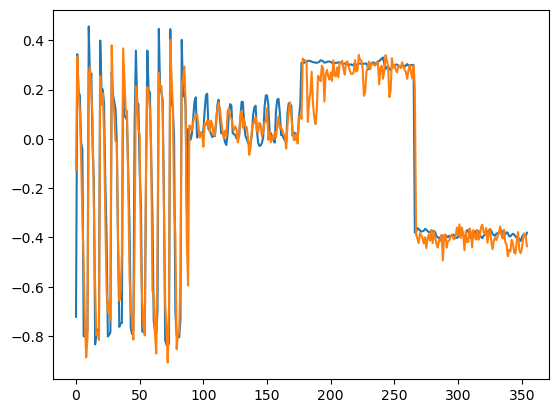

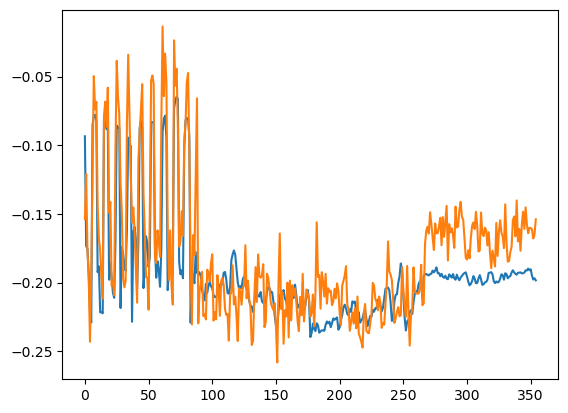

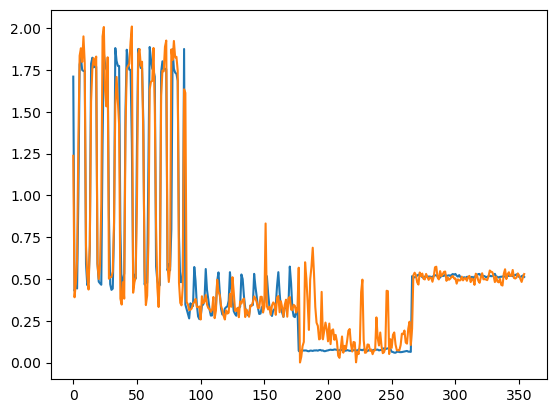

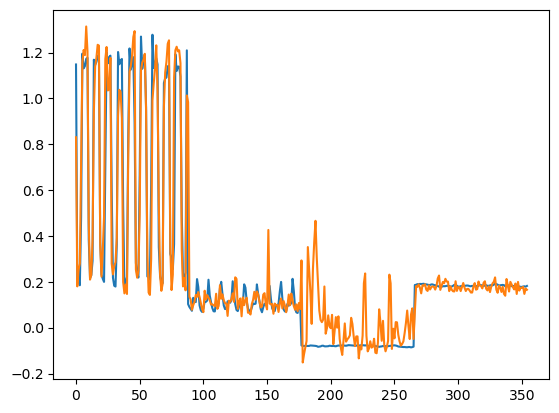

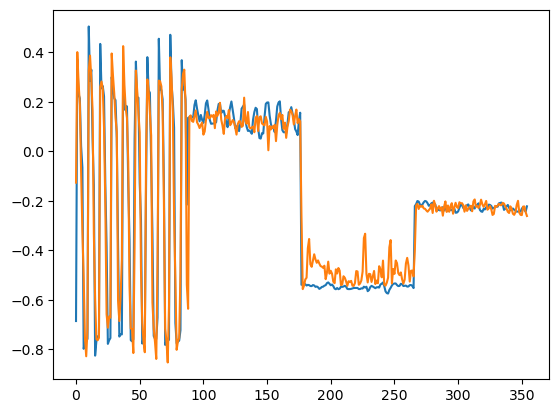

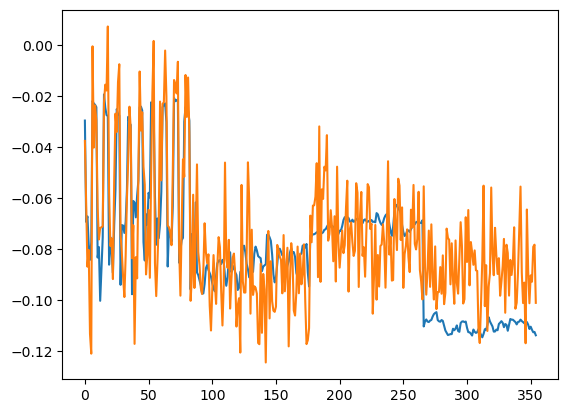

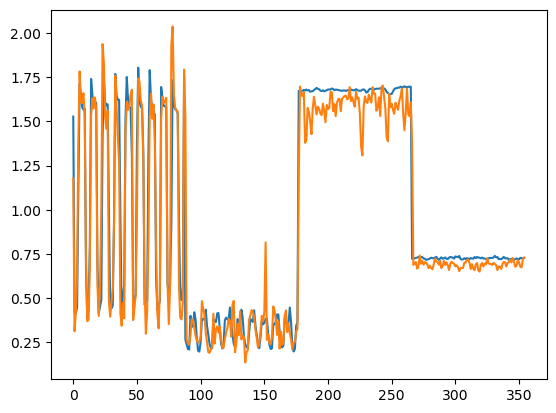

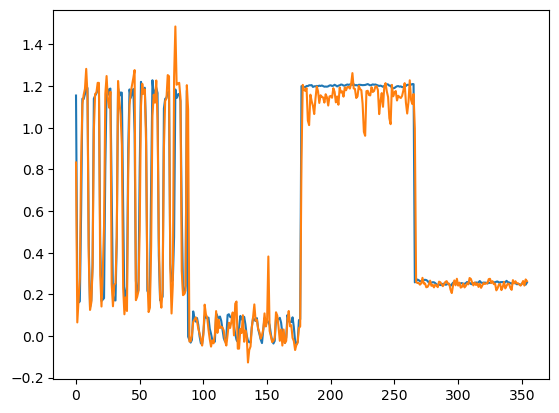

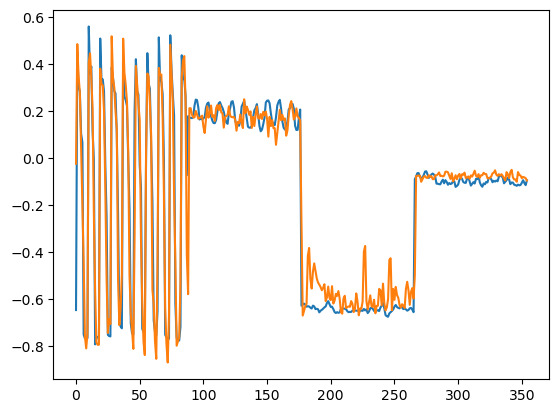

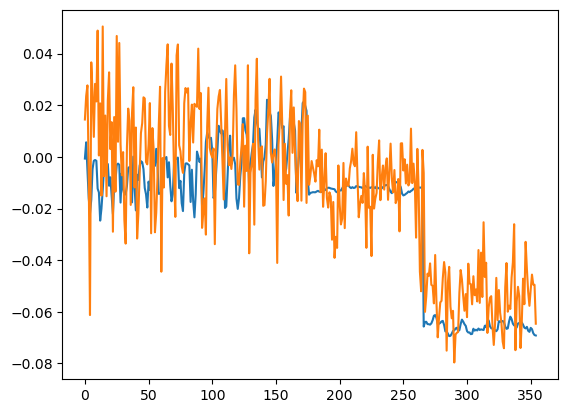

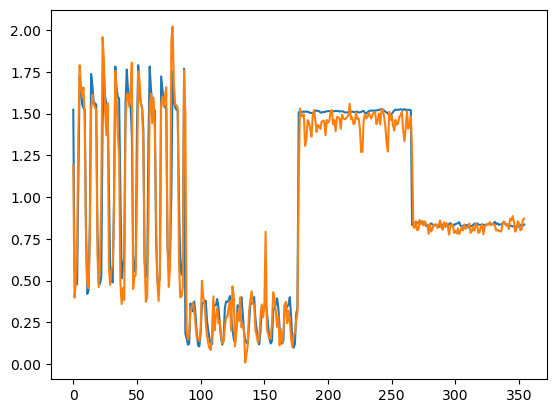

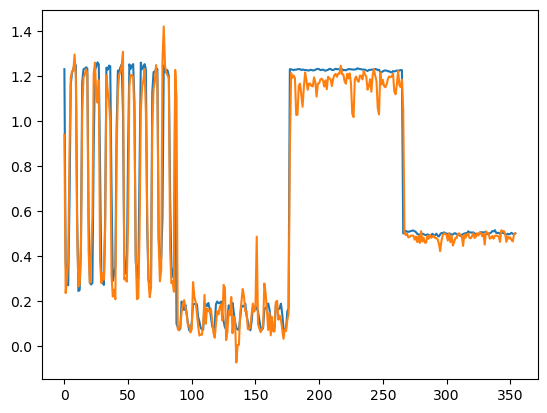

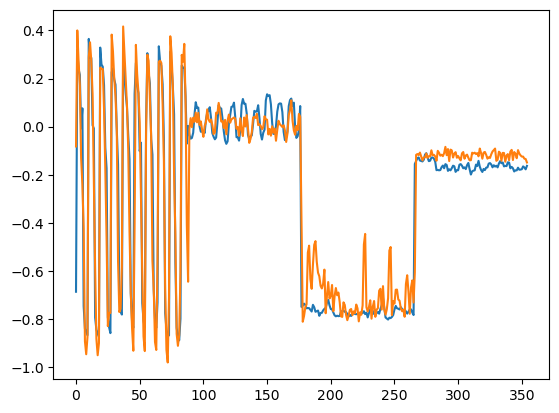

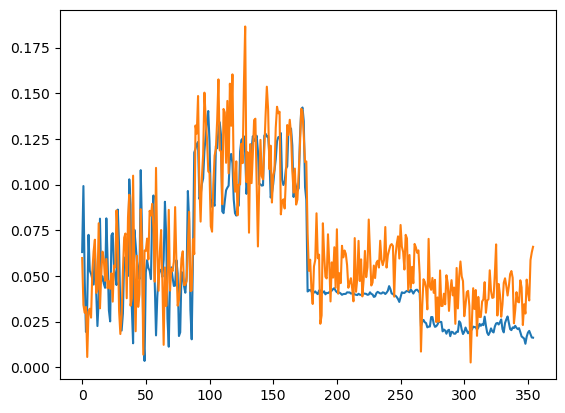

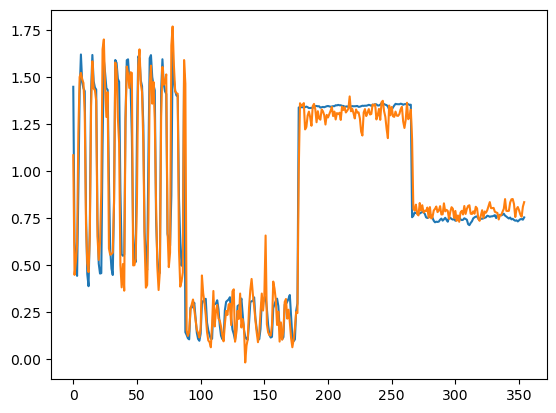

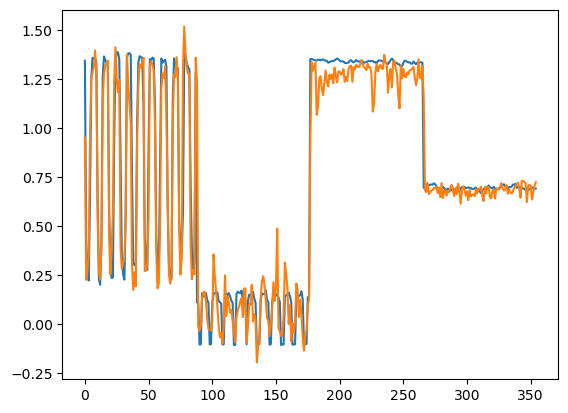

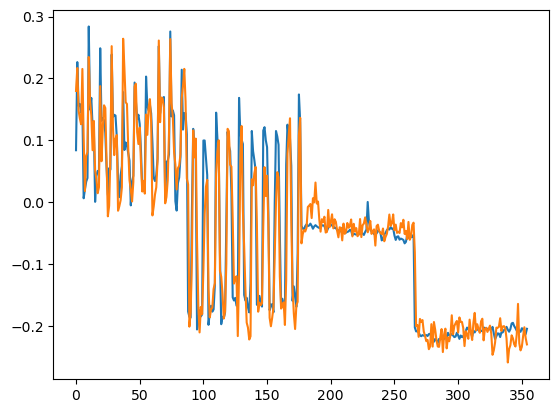

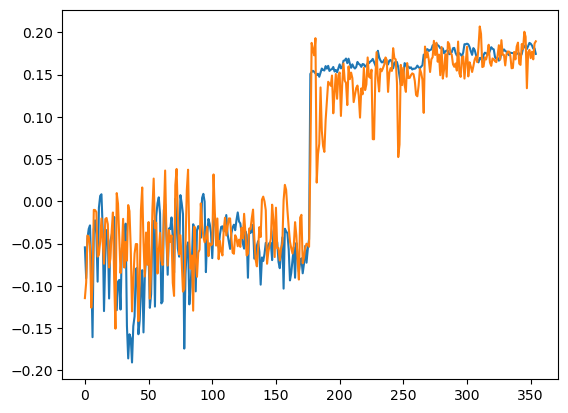

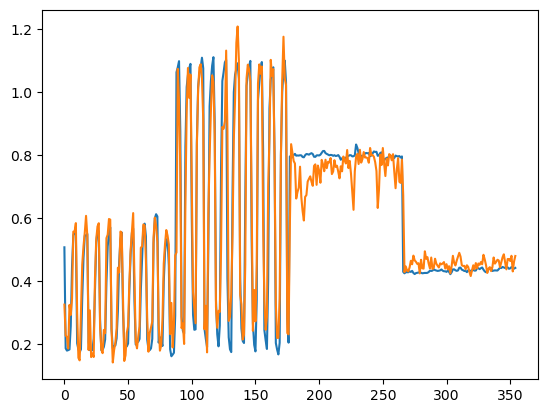

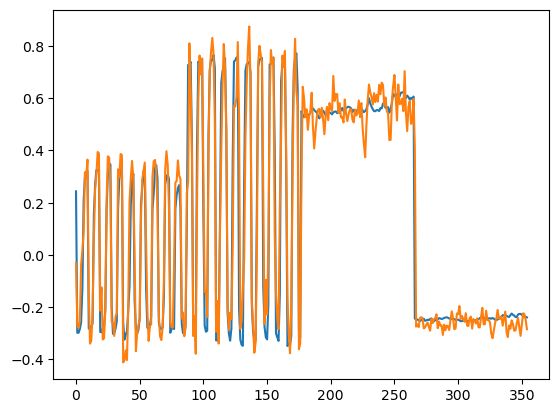

In [11]:
for i in range(y_test.shape[1]):
    plt.figure()
    plt.plot(y_test[:, i])
    plt.plot(y_pipeline_pred[:, i])

### Pipeline from scratch

In [ ]:
class Covariances:
    def __init__(self, estimator="oas"):
        self.estimator = estimator

    def fit_transform(self, X):
        # X.shape = (n_trials, n_channels, n_samples)
        covmats = []
        for trial in X:
            covmats.append(self._compute_cov(trial))
        return np.array(covmats)

    def transform(self, X):
        # Аналогично fit_transform, если параметры оценки уже заданы.
        return self.fit_transform(X)

    def _compute_cov(self, X):
        """
        Рассчитывает ковариационную матрицу для одного испытания X (shape: [n_channels, n_samples])
        с использованием подхода OAS.
        """
        # Центрируем данные по каждому каналу
        Xc = X - np.mean(X, axis=1, keepdims=True)
        n_channels, n_samples = Xc.shape

        # Стандартная оценка выборочной ковариационной матрицы:
        sample_cov = (Xc @ Xc.T) / (n_samples - 1)

        if self.estimator.lower() == "oas":
            # Вычисляем след и сумму квадратов всех элементов (trace_S2)
            trace_S = np.trace(sample_cov)
            trace_S2 = np.sum(sample_cov**2)

            # Вычисление коэффициента shrinkage (α)
            shrinkage = min(
                1.0,
                ((1 - 2.0 / n_channels) * trace_S2 + trace_S**2)
                / (
                    (n_samples + 1 - 2.0 / n_channels)
                    * (trace_S2 - (trace_S**2) / n_channels)
                ),
            )
            # Целевая матрица – диагональная с элементами mu = trace_S / n_channels
            mu = trace_S / n_channels
            shrunk_cov = (1 - shrinkage) * sample_cov + shrinkage * mu * np.eye(
                n_channels
            )
            return shrunk_cov
        else:
            # Можно добавить поддержку других оценок. По умолчанию - sample covariance.
            return sample_cov


def sqrtm(A):
    """Вычисляет матричный квадратный корень A^(1/2) через собственное разложение."""
    eigvals, eigvecs = np.linalg.eigh(A)
    # Защита от отрицательных значений (ошибки округления)
    eigvals = np.maximum(eigvals, 0)
    sqrt_eig = np.sqrt(eigvals)
    return eigvecs @ np.diag(sqrt_eig) @ eigvecs.T


def inv_sqrtm(A):
    """Вычисляет обратный квадратный корень A^(-1/2) через собственное разложение."""
    eigvals, eigvecs = np.linalg.eigh(A)
    # Избегаем деления на ноль (малые положительные значения)
    eigvals = np.maximum(eigvals, 1e-12)
    inv_sqrt_eig = 1.0 / np.sqrt(eigvals)
    return eigvecs @ np.diag(inv_sqrt_eig) @ eigvecs.T


def logm(A):
    """Вычисляет матричный логарифм лог(A) через собственное разложение."""
    eigvals, eigvecs = np.linalg.eigh(A)
    # Защита от очень малых значений
    eigvals = np.maximum(eigvals, 1e-12)
    log_eig = np.log(eigvals)
    return eigvecs @ np.diag(log_eig) @ eigvecs.T


def expm(A):
    """Вычисляет матричную экспоненту exp(A) через собственное разложение."""
    eigvals, eigvecs = np.linalg.eigh(A)
    exp_eig = np.exp(eigvals)
    return eigvecs @ np.diag(exp_eig) @ eigvecs.T


def riemannian_mean(covs, tol=1e-6, max_iter=50):
    """
    Вычисляет Риманово среднее (геометрическое среднее) ковариационных матриц.
    covs: массив ковариационных матриц (n_matrices, n_channels, n_channels)
    """
    n_matrices = covs.shape[0]
    # Инициализируем арифметическим средним
    M = np.mean(covs, axis=0)

    for i in range(max_iter):
        inv_sqrt_M = inv_sqrtm(M)
        logs = np.zeros_like(M)
        for C in covs:
            T = logm(inv_sqrt_M @ C @ inv_sqrt_M)
            logs += T
        logs /= n_matrices
        M_new = sqrtm(M) @ expm(logs) @ sqrtm(M)
        # Проверка сходимости по норме Фробениуса
        if np.linalg.norm(M_new - M, ord="fro") / np.linalg.norm(M, ord="fro") < tol:
            M = M_new
            break
        M = M_new
    return M


class TangentSpace:
    def __init__(self, metric="riemann"):
        self.metric = metric
        self.ref_ = None

    def fit_transform(self, covs):
        """
        covs: массив ковариационных матриц размера (n_matrices, n_channels, n_channels)
        """
        if self.metric == "riemann":
            self.ref_ = riemannian_mean(covs)
        else:
            # По умолчанию арифметическое среднее
            self.ref_ = np.mean(covs, axis=0)
        return self.transform(covs)

    def transform(self, covs):
        """
        Проецирует каждую ковариационную матрицу в тангенциальное пространство.
        Возвращает массив векторизованных форм проекций.
        """
        inv_sqrt_ref = inv_sqrtm(self.ref_)
        n_matrices = covs.shape[0]
        n_channels = covs.shape[1]
        ts = []
        for C in covs:
            # Вычисляем матрицу: T = log( ref^{-1/2} * C * ref^{-1/2} )
            T = logm(inv_sqrt_ref @ C @ inv_sqrt_ref)
            # Векторизуем симметричную матрицу: выбираем верхнетреугольные элементы (включая диагональ)
            vec = T[np.triu_indices(n_channels)]
            ts.append(vec)
        return np.array(ts)


class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state

        # Внутренние объекты моделей
        self.cov_ = None
        self.ts_ = None
        self.reg_ = None

    def fit(self, X, y):
        # 1. Вычисление ковариационных матриц
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)

        # 2. Проекция в тангенциальное пространство
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        # 3. MLP Regressor
        self.reg_ = MLPRegressor(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation=self.activation,
            solver=self.solver,
            alpha=self.alpha,
            max_iter=self.max_iter,
            random_state=self.random_state,
        )
        self.reg_.fit(X_ts, y)
        return self

    def predict(self, X):
        # Применение тех же преобразований к новым данным
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        return self.reg_.predict(X_ts)


# Пример использования:
# Пусть X_train имеет размер (3195, 6, 250), y_train – (3195, 20)
np.random.seed(42)
# X_train = np.random.randn(3195, 6, 250)
# y_train = np.random.randn(3195, 20)

model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(200,),
    activation="relu",
    solver="adam",
    alpha=1e-5,
    max_iter=300,
    random_state=42,
)

model.fit(X_train, y_train)
y_model_pred = model.predict(X_test)

results = {}
correlations = []
for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )

### Pipeline and torch mlp block

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TorchMLP(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, activation="relu"):
        super(TorchMLP, self).__init__()
        layers = []
        current_dim = input_dim
        # nn.GELU, nn.Softshrink
        act_layer = nn.GELU
        for h in hidden_layer_sizes:
            layers.append(nn.Linear(current_dim, h))
            layers.append(act_layer())
            current_dim = h
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
        device="cpu",
        batch_size=64,
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state
        self.device = device
        self.batch_size = batch_size
        self.verbose = verbose

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X, y):
        # Ковариации и тангенциальное пространство
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)

        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.float32).to(self.device)

        input_dim = X_ts.shape[1]
        output_dim = y.shape[1]

        self.model_ = TorchMLP(
            input_dim=input_dim,
            hidden_layer_sizes=self.hidden_layer_sizes,
            output_dim=output_dim,
            activation=self.activation,
        ).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=0.001, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

        dataset = torch.utils.data.TensorDataset(X_ts, y)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True
        )

        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                output = self.model_(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(loader)

            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{self.max_iter}, Avg Loss: {avg_loss:.4f}")

            scheduler.step()

        return self

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(X_ts).cpu().numpy()
        return preds


model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(400, 400),
    activation="relu",
    max_iter=1000,
    alpha=1e-5,
    random_state=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

model.fit(X_train, y_train)
y_model_pred = model.predict(X_test)

results = {}
correlations = []
for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


# class TorchMLP(nn.Module):
#     def __init__(self, input_dim, hidden_layer_sizes, output_dim, activation="relu"):
#         super(TorchMLP, self).__init__()
#         layers = []
#         current_dim = input_dim
#         act_layer = nn.GELU  # Можно подставить nn.ReLU() или другую
#         for h in hidden_layer_sizes:
#             layers.append(nn.Linear(current_dim, h))
#             layers.append(act_layer())
#             current_dim = h
#         layers.append(nn.Linear(current_dim, output_dim))
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)


class TorchMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layer_sizes: list,
        output_dim: int,
        activation: str = "gelu",
        dropout_rate: float = 0.2,
        use_bn: bool = True,
        residual_connections: bool = False,
        init_method: str = "he",
    ):
        super(TorchMLP, self).__init__()
        self.residual_connections = residual_connections

        # Выбор активации
        activation_dict = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "selu": nn.SELU,
            "leaky_relu": nn.LeakyReLU,
            "swish": nn.SiLU,
        }
        act_layer = activation_dict.get(activation.lower(), nn.GELU)

        layers = []
        current_dim = input_dim

        # Построение скрытых слоев
        for i, h in enumerate(hidden_layer_sizes):
            # Линейный слой
            layers.append(nn.Linear(current_dim, h))

            # Инициализация весов
            if init_method == "he":
                nn.init.kaiming_normal_(layers[-1].weight, nonlinearity="relu")
            elif init_method == "xavier":
                nn.init.xavier_normal_(layers[-1].weight)

            # Batch Normalization
            if use_bn:
                layers.append(nn.BatchNorm1d(h))

            # Активация
            layers.append(act_layer())

            # Dropout
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            # Обновление размерности
            current_dim = h

        # Выходной слой
        self.output_layer = nn.Linear(current_dim, output_dim)

        # Инициализация выходного слоя
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0)

        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            if isinstance(layer, nn.Linear) and self.residual_connections:
                if x.shape[-1] == layer.out_features:
                    residual = x
                x = layer(x)
                if x.shape == residual.shape:
                    x += residual
                    residual = x
            else:
                x = layer(x)
        return self.output_layer(x)


class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
        device="cpu",
        batch_size=64,
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state
        self.device = device
        self.batch_size = batch_size
        self.verbose = verbose

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    # Изменённый метод fit принимает дополнительно X_val и y_val для вычисления тестового лосса и корреляции
    def fit(self, X, y, X_val=None, y_val=None):
        # Вычисление ковариаций и переход в тангенциальное пространство
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)

        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        input_dim = X_ts.shape[1]
        output_dim = y_tensor.shape[1]

        # self.model_ = TorchMLP(
        #     input_dim=input_dim,
        #     hidden_layer_sizes=self.hidden_layer_sizes,
        #     output_dim=output_dim,
        #     activation=self.activation,
        # ).to(self.device)

        self.model_ = TorchMLP(
            input_dim=input_dim,
            hidden_layer_sizes=self.hidden_layer_sizes,
            output_dim=output_dim,
            activation=self.activation,
            dropout_rate=0,
            use_bn=False,
            residual_connections=False,
            init_method="no",
        ).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=0.001, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

        dataset = torch.utils.data.TensorDataset(X_ts, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True
        )

        # Если заданы данные для валидации, подготовим их
        if (X_val is not None) and (y_val is not None):
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)
            X_ts_val = torch.tensor(X_ts_val, dtype=torch.float32).to(self.device)
            y_tensor_val = torch.tensor(y_val, dtype=torch.float32).to(self.device)

        # Обучение модели
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                output = self.model_(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            scheduler.step()

            # Каждые 50 эпох (или можно менять условие) вычисляем и выводим метрики
            if self.verbose and ((epoch + 1) % 50 == 0):
                # Рассчёт метрик на тренировочных данных
                self.model_.eval()
                with torch.no_grad():
                    # Предсказания на тренинге
                    train_preds = self.model_(X_ts).cpu().numpy()
                    train_loss = criterion(self.model_(X_ts), y_tensor).item()

                    # Вычисление корреляции по каждому выходу
                    train_corrs = []
                    y_true_np = y_tensor.cpu().numpy()
                    for i in range(train_preds.shape[1]):
                        train_corrs.append(corrcoef(train_preds[:, i], y_true_np[:, i]))
                    train_mean_corr = np.nanmean(train_corrs)

                    metrics_str = f"Epoch {epoch+1}/{self.max_iter}: Train Loss: {train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                    # Если есть валидация – аналогичные расчёты
                    if (X_val is not None) and (y_val is not None):
                        val_preds = self.model_(X_ts_val).cpu().numpy()
                        val_loss = criterion(self.model_(X_ts_val), y_tensor_val).item()
                        val_corrs = []
                        y_val_np = y_tensor_val.cpu().numpy()
                        for i in range(val_preds.shape[1]):
                            val_corrs.append(corrcoef(val_preds[:, i], y_val_np[:, i]))
                        val_mean_corr = np.nanmean(val_corrs)
                        metrics_str += (
                            f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                        )

                    print(metrics_str)

        return self

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(X_ts).cpu().numpy()
        return preds


model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(256, 256),
    activation="gelu",
    max_iter=100,
    alpha=1e-5,
    random_state=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

model.fit(X_train, y_train, X_test, y_test)
y_model_pred = model.predict(X_test)

results = {}
correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    # corr
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    # r2
    try:
        r2 = r2_score(y_test[:, i], y_model_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}')
    print(f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n')

X_cov.shape: (1599, 6, 6)
X_ts.shape: (1599, 21)
Epoch 50/100: Train Loss: 0.0055, Train Corr: 0.967, Val Loss: 0.0111, Val Corr: 0.944
Epoch 100/100: Train Loss: 0.0037, Train Corr: 0.975, Val Loss: 0.0115, Val Corr: 0.945
model:
  Mean correlation: 0.945 ± 0.031
  Individual correlations: ['0.970', '0.900', '0.972', '0.972', '0.952', '0.845', '0.955', '0.961', '0.955', '0.938', '0.954', '0.957', '0.953', '0.883', '0.952', '0.956', '0.942', '0.957', '0.955', '0.961']

  Mean R2: 0.888 ± 0.061
  Individual R2: ['0.939', '0.807', '0.941', '0.944', '0.906', '0.705', '0.911', '0.922', '0.912', '0.829', '0.908', '0.915', '0.907', '0.770', '0.904', '0.913', '0.887', '0.916', '0.911', '0.922']



In [16]:
y_test.shape

(177, 20)

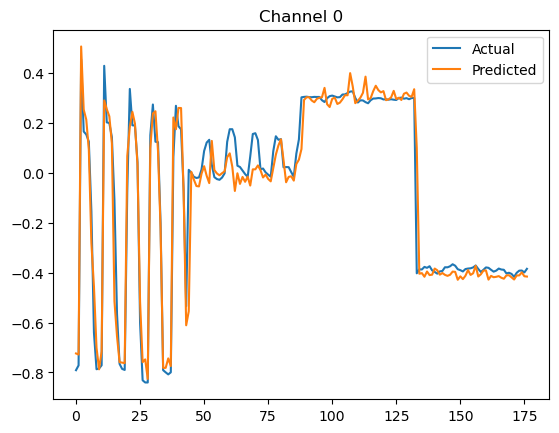

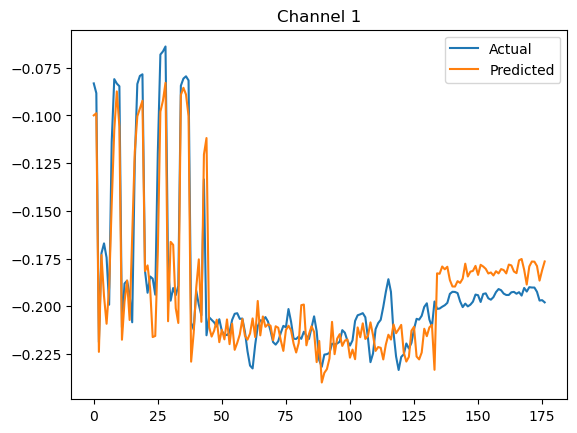

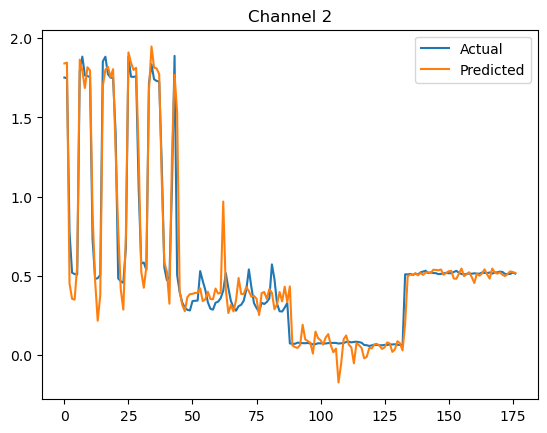

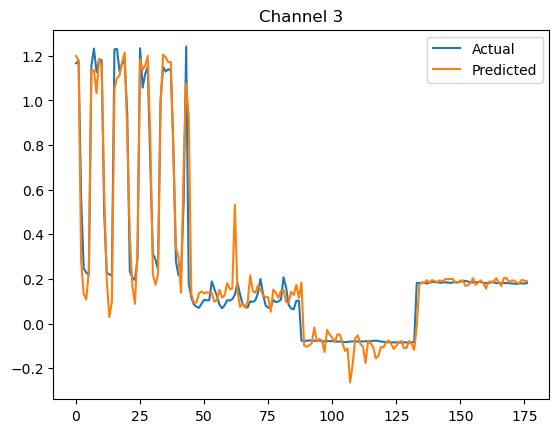

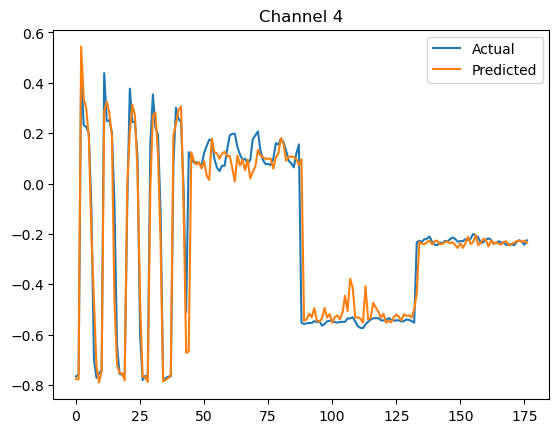

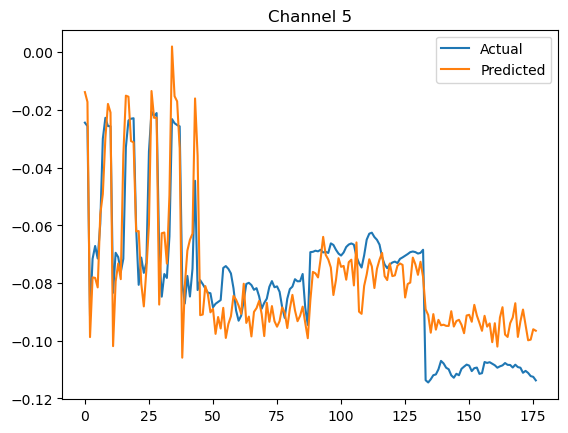

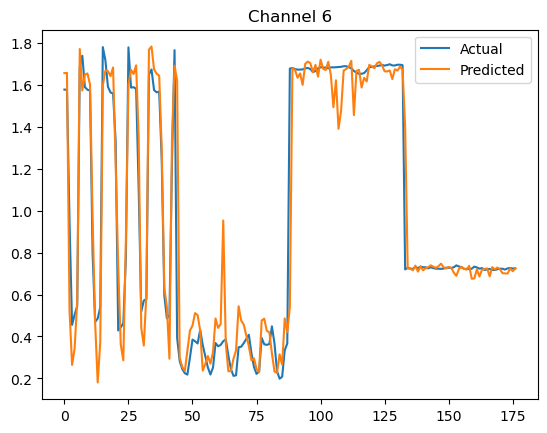

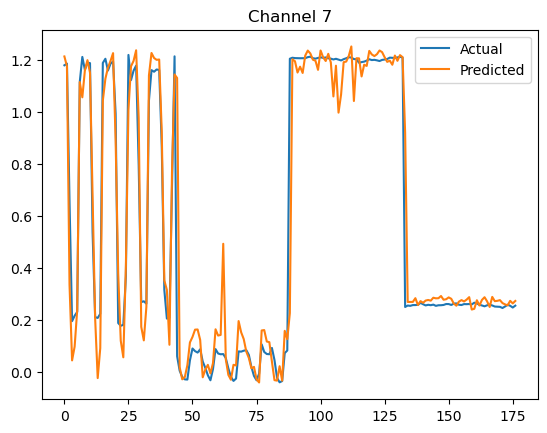

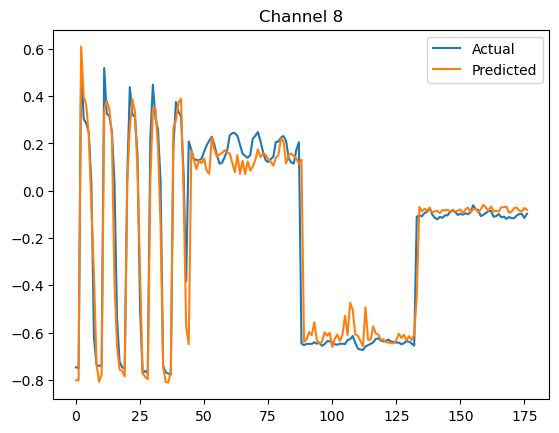

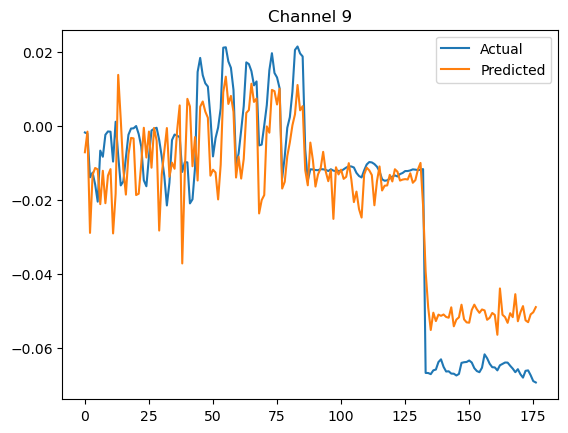

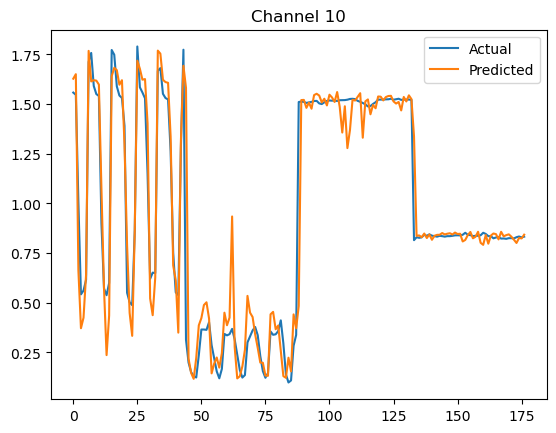

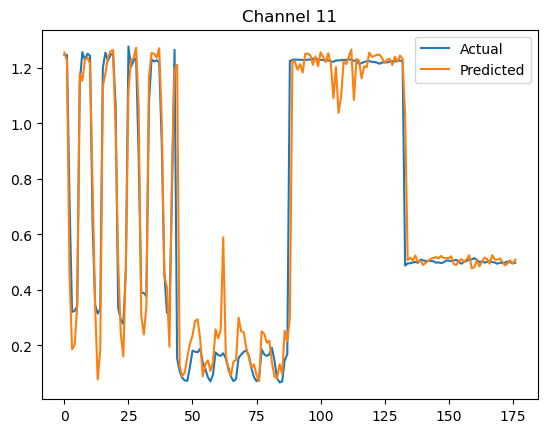

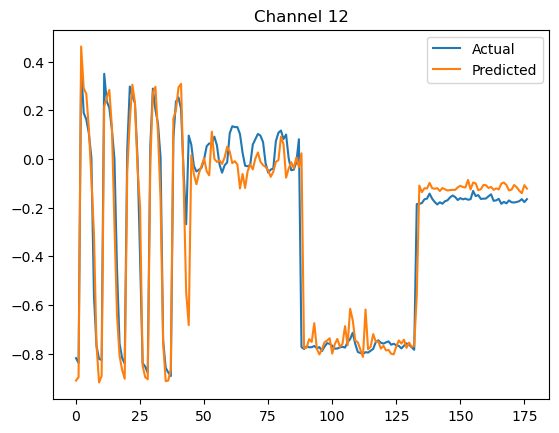

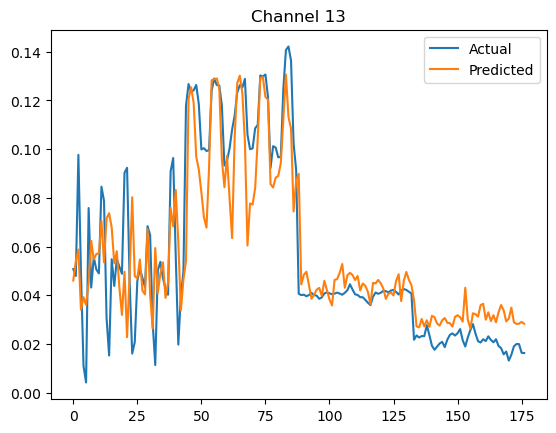

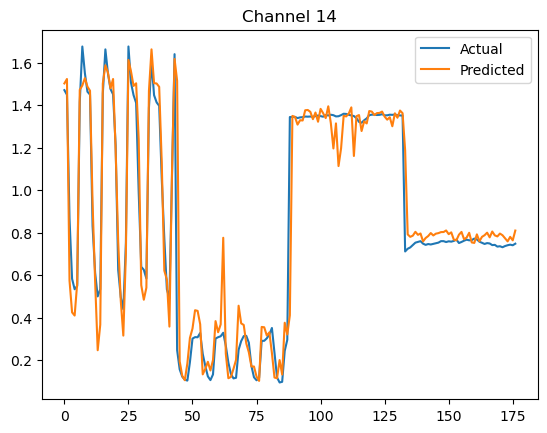

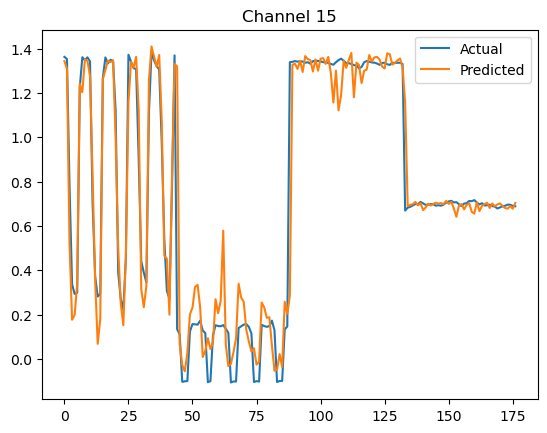

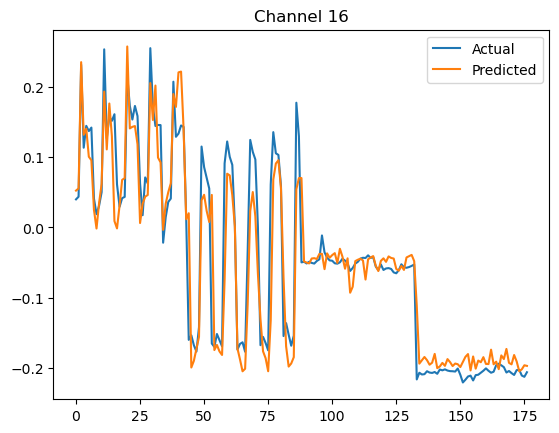

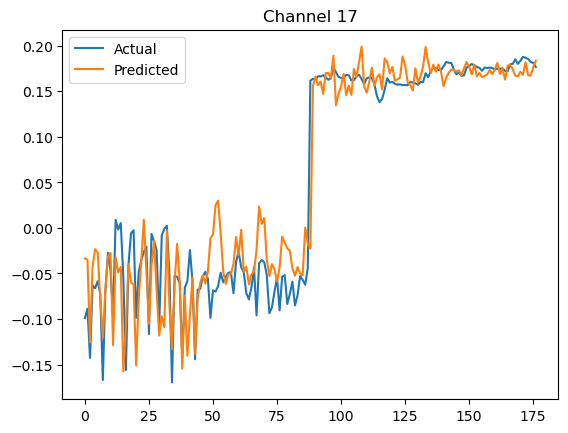

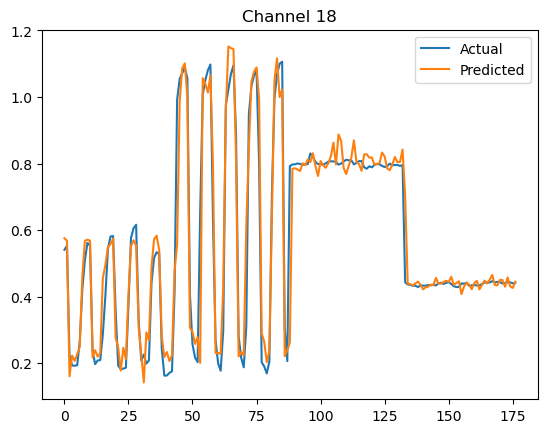

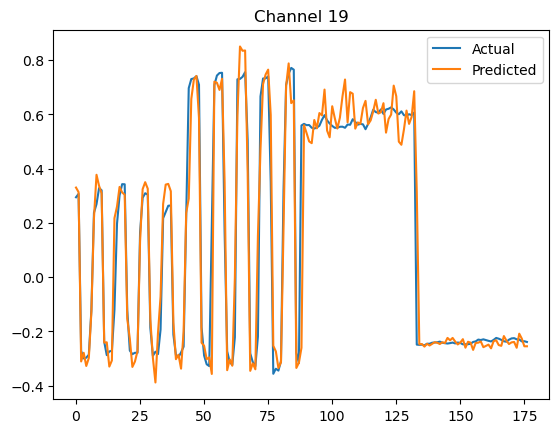

In [ ]:
for i in range(y_test.shape[1]):
    plt.figure()
    plt.plot(y_test[:, i])
    plt.plot(y_model_pred[:, i])
    plt.legend(["Actual", "Predicted"])
    plt.title(f"Channel {i}")

### History prediction

In [ ]:
# Data
subj_path = "..\\data\\Fedor\\Raw\\preproc_angles\\1\\"
fs = 500


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    data_test = data[l_idx:h_idx, :]

    return data_train, data_test


N_files = 4
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)

    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc

    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


def slicer_sequence(data, label, fs, windowlen=500, timestep=100, seq_len=5):
    """
    Формирует последовательности для каждого окна EMG-сигнала, извлекая также историю предыдущих углов движения.
    Возвращает:
      - slice_data: исходные данные EMG для обработки ковариациями
      - prev_angles: последовательность (конкатенация) предыдущих углов
      - slice_label: целевое значение углов (следующий момент после окна)
    """
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)

    # Индексы стартовых точек, начиная с момента, когда уже накоплена история seq_len
    start_indices = np.arange(
        seq_len * timestep_samples, data_len - windowlen_samples, timestep_samples
    )

    slice_data = []
    prev_angles = []
    slice_label = []

    for idx in start_indices:
        # Извлекаем историю: собираем значения углов за seq_len предыдущих шагов
        history = []
        for i in range(seq_len):
            offset = idx - (seq_len - i) * timestep_samples
            # Можно взять значение углов сразу после соответствующего окна
            history.append(label[offset + windowlen_samples])
        # Объединяем историю в единый вектор
        history = np.concatenate(history, axis=0)
        prev_angles.append(history)

        # Извлекаем EMG-сигнал за текущее окно
        window_idx = np.arange(idx, idx + windowlen_samples)
        slice_data.append(data[window_idx, :])
        # Целевая метка – углы движения сразу после окна
        slice_label.append(label[idx + windowlen_samples])

    return (
        np.array(slice_data).transpose(0, 2, 1),
        np.array(prev_angles),
        np.array(slice_label),
    )


# X_train, y_train = slicer(data_train, label_train, fs)
# X_test, y_test = slicer(data_test, label_test, fs)

X_train_emg, X_train_history, y_train = slicer_sequence(
    data_train, label_train, fs, seq_len=5
)
X_test_emg, X_test_history, y_test = slicer_sequence(
    data_test, label_test, fs, seq_len=5
)

In [ ]:
# Простейший MLP для объединения признаков из Тангенциального пространства и истории углов
class DualInputMLP(nn.Module):
    def __init__(
        self,
        ts_input_dim,
        history_dim,
        hidden_sizes=(400, 400),
        output_dim=20,
        dropout=0.2,
    ):
        super(DualInputMLP, self).__init__()
        combined_dim = ts_input_dim + history_dim  # В нашем случае 21 + (seq_len * 20)
        layers = []
        current_dim = combined_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(current_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            current_dim = h
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, ts_features, history_features):
        # Конкатенация признаков из тангенциального пространства и истории
        x = torch.cat((ts_features, history_features), dim=1)
        out = self.model(x)
        return out


class RiemannMLPRegressorWithHistory(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(400, 400),
        alpha=1e-5,
        max_iter=100,
        random_state=42,
        device="cpu",
        batch_size=64,
        verbose=False,
        seq_len=5,  # Количество предыдущих шагов для истории углов
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state
        self.device = device
        self.batch_size = batch_size
        self.verbose = verbose
        self.seq_len = seq_len

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X_emg, X_history, y):
        """
        X_emg: массив с исходными срезами ЭМГ-сигнала (например, размер (3195, windowlen_samples, n_channels))
        X_history: массив с векторами истории углов (например, размер (3195, seq_len*20))
        y: целевые значения углов (например, размер (3195, 20))
        """
        # 1. Преобразование ЭМГ-сигнала через ковариации и тангенциальное пространство
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(
            X_emg
        )  # X_cov.shape должно быть (N_samples, 6, 6)

        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)  # X_ts.shape будет (N_samples, 21)
        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)

        # Преобразуем данные в тензоры
        X_ts_tensor = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        history_tensor = torch.tensor(X_history, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        ts_input_dim = X_ts_tensor.shape[1]  # 21
        history_dim = history_tensor.shape[1]
        output_dim = y_tensor.shape[1]  # 20

        self.model_ = DualInputMLP(
            ts_input_dim, history_dim, self.hidden_layer_sizes, output_dim
        ).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=0.001, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

        dataset = torch.utils.data.TensorDataset(X_ts_tensor, history_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True
        )

        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0
            for ts_batch, history_batch, y_batch in loader:
                optimizer.zero_grad()
                preds = self.model_(ts_batch, history_batch)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            if self.verbose and (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{self.max_iter}, Loss: {epoch_loss:.4f}")

            scheduler.step()

        return self

    def val(self, X_emg, X_history):
        X_cov = self.cov_.transform(X_emg)
        X_ts = self.ts_.transform(X_cov)

        X_ts_tensor = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        history_tensor = torch.tensor(X_history, dtype=torch.float32).to(self.device)

        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(X_ts_tensor, history_tensor).cpu().numpy()
        return preds

    def predict(self, X_emg, initial_history=None):
        """
        Авто-регрессионный инференс:
        - X_emg: массив с срезами ЭМГ-сигнала, например (N_samples, windowlen_samples, n_channels)
        - initial_history: начальное значение истории, размер (seq_len, output_dim).
            Если не передано, используется нулевая инициализация.
        Возвращает:
        - numpy-массив предсказаний, размер (N_samples, output_dim)
        """
        # Определяем выходную размерность (число углов). Предполагаем, что последний слой модели имеет атрибут out_features.
        output_dim = self.model_.model[-1].out_features

        # Если начальная история не задана, инициализируем её нулями
        if initial_history is None:
            history_vec = np.zeros((self.seq_len, output_dim))
        else:
            # Если передана история, приводим её к нужному виду
            history_vec = np.array(initial_history).reshape(self.seq_len, output_dim)

        predictions = []
        num_samples = X_emg.shape[0]

        for i in range(num_samples):
            # Извлекаем текущее окно ЭМГ (форма: [windowlen_samples, n_channels])
            current_emg = X_emg[i]

            # Преобразуем текущее окно через Covariances и TangentSpace:
            X_cov = self.cov_.transform(
                np.expand_dims(current_emg, axis=0)
            )  # форма: (1, 6, 6)
            X_ts = self.ts_.transform(X_cov)  # форма: (1, 21)

            # Формируем историю в виде вектора: преобразуем массив history_vec (seq_len, output_dim)
            # в одномерный вектор размерности seq_len*output_dim и добавляем размерность пакета (1, ...)
            history_input = history_vec.flatten()[
                np.newaxis, :
            ]  # форма: (1, seq_len*output_dim)

            # Приводим данные к тензорам PyTorch:
            ts_tensor = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
            hist_tensor = torch.tensor(history_input, dtype=torch.float32).to(
                self.device
            )

            # Выполняем предсказание:
            self.model_.eval()
            with torch.no_grad():
                pred_tensor = self.model_(ts_tensor, hist_tensor)
            pred = pred_tensor.cpu().numpy()[0]

            predictions.append(pred)

            # Обновляем историю:
            # Сдвигаем историю на один шаг влево и ставим новое предсказание в конец
            history_vec = np.roll(history_vec, shift=-1, axis=0)
            history_vec[-1, :] = pred

        return np.array(predictions)


model = RiemannMLPRegressorWithHistory(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(400, 400),
    max_iter=1000,
    alpha=1e-5,
    random_state=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
    seq_len=5,
)

model.fit(X_train_emg, X_train_history, y_train)
y_model_pred = model.val(X_test_emg, X_test_history)

results = {}
correlations = []
for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )

In [ ]:
y_model_pred = model.predict(X_test_emg)

results = {}
correlations = []
for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )

In [ ]:
for i in range(y_test.shape[1]):
    plt.figure()
    plt.plot(y_test[:, i])
    plt.plot(y_model_pred[:, i])

#### Autoregressive Mode

In [ ]:
# ----------------------------
# Код подготовки данных
# ----------------------------
subj_path = "..\\data\\Fedor\\Raw\\preproc_angles\\1\\"
fs = 500


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    data_test = data[l_idx:h_idx, :]

    return data_train, data_test


N_files = 4
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):
    arr = np.load(subj_path + "000" + str(i) + ".npz")
    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)
    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer_sequence(data, label, fs, windowlen=500, timestep=100, seq_len=5):
    """
    Формирует последовательности для каждого окна EMG-сигнала, извлекая также историю предыдущих углов движения.
    Возвращает:
      - slice_data: исходные данные EMG для обработки ковариациями
      - prev_angles: последовательность (конкатенация) предыдущих углов (ground truth; используется для начальной инициализации)
      - slice_label: целевое значение углов (следующий момент после окна)
    """
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)

    # Индексы стартовых точек, начиная с момента, когда уже накоплена история seq_len
    start_indices = np.arange(
        seq_len * timestep_samples, data_len - windowlen_samples, timestep_samples
    )

    slice_data = []
    prev_angles = []
    slice_label = []

    for idx in start_indices:
        # Извлекаем историю: собираем значения углов за seq_len предыдущих шагов
        history = []
        for i in range(seq_len):
            offset = idx - (seq_len - i) * timestep_samples
            history.append(label[offset + windowlen_samples])
        # Объединяем историю в единый вектор
        history = np.concatenate(history, axis=0)
        prev_angles.append(history)

        # Извлекаем EMG-сигнал за текущее окно
        window_idx = np.arange(idx, idx + windowlen_samples)
        slice_data.append(data[window_idx, :])
        # Целевая метка – углы движения сразу после окна
        slice_label.append(label[idx + windowlen_samples])

    # Транспонируем slice_data, чтобы получить форму (N_samples, n_channels, windowlen_samples)
    return (
        np.array(slice_data).transpose(0, 2, 1),
        np.array(prev_angles),
        np.array(slice_label),
    )


# Формируем обучающую и тестовую выборки
X_train_emg, X_train_history, y_train = slicer_sequence(
    data_train, label_train, fs, seq_len=5
)
X_test_emg, X_test_history, y_test = slicer_sequence(
    data_test, label_test, fs, seq_len=5
)

In [ ]:
# ----------------------------
# Код обучения модели с авто-регрессивной историей и teacher forcing
# ----------------------------
# Простейший MLP для объединения признаков из Тангенциального пространства и истории углов
class DualInputMLP(nn.Module):
    def __init__(
        self,
        ts_input_dim,
        history_dim,
        hidden_sizes=(400, 400),
        output_dim=20,
        dropout=0.2,
    ):
        super(DualInputMLP, self).__init__()
        combined_dim = ts_input_dim + history_dim  # В нашем случае 21 + (seq_len * 20)
        layers = []
        current_dim = combined_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(current_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            current_dim = h
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, ts_features, history_features):
        # Конкатенация признаков из тангенциального пространства и истории
        x = torch.cat((ts_features, history_features), dim=1)
        out = self.model(x)
        return out


class RiemannMLPRegressorWithHistory(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(400, 400),
        alpha=1e-5,
        max_iter=1000,
        random_state=42,
        device="cpu",
        teacher_forcing_ratio=0.5,  # Вероятность использования ground truth для обновления истории
        seq_len=5,  # Количество предыдущих шагов для истории углов
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.seq_len = seq_len

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X_emg, X_history, y):
        """
        Авто-регрессивное обучение с data augmentation в виде teacher forcing.
        Поскольку мы хотим, чтобы модель училась работать с историей, составленной из собственных предсказаний,
        в обучении мы игнорируем входной X_history и используем ground truth только для начальной инициализации истории.

        Аргументы:
          X_emg: массив с EMG-окнами, размер (N_samples, windowlen_samples, n_channels)
          y: массив с целевыми углами, размер (N_samples, 20)
        """
        # Вычисляем ковариационные матрицы и признаки в тангенциальном пространстве для всех примеров
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X_emg)  # (N_samples, 6, 6)

        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)  # (N_samples, 21)
        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)

        # Приводим данные к тензорам
        X_ts_tensor = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        # Определяем размеры
        ts_input_dim = X_ts_tensor.shape[1]  # 21
        output_dim = y_tensor.shape[1]  # 20
        history_dim = self.seq_len * output_dim  # например, 5*20

        # Инициализируем модель
        self.model_ = DualInputMLP(
            ts_input_dim, history_dim, self.hidden_layer_sizes, output_dim
        ).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=0.001, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

        N = X_ts_tensor.shape[0]

        # Обучаем модель проходом по всей последовательности в порядке времени.
        for epoch in range(self.max_iter):
            self.model_.train()
            losses = []

            # Инициализируем историю первыми seq_len ground truth значениями
            # history: numpy-массив размера (seq_len, output_dim)
            history = y_tensor[: self.seq_len].detach().cpu().numpy().copy()

            # Проходим по последовательности начиная с индекса seq_len
            for t in range(self.seq_len, N):
                # Текущий TS-признак: форма (1, ts_input_dim)
                ts_input = X_ts_tensor[t].unsqueeze(0)
                # Формируем входную историю как вектор: (1, seq_len*output_dim)
                history_input = torch.tensor(
                    history.flatten()[np.newaxis, :], dtype=torch.float32
                ).to(self.device)

                pred = self.model_(ts_input, history_input)  # (1, output_dim)
                loss = criterion(pred, y_tensor[t].unsqueeze(0))
                losses.append(loss)

                # Определяем, использовать ли ground truth (teacher forcing)
                if np.random.rand() < self.teacher_forcing_ratio:
                    new_val = y_tensor[t].detach().cpu().numpy()
                else:
                    new_val = pred.detach().cpu().numpy()[0]

                # Обновляем историю: сдвигаем на один шаг и добавляем новое значение
                history = np.roll(history, shift=-1, axis=0)
                history[-1, :] = new_val

            # Обновление параметров после прохождения всей последовательности
            total_loss = sum(losses) / len(losses)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            scheduler.step()

            if (epoch + 1) % 50 == 0:
                print(
                    f"Epoch {epoch+1}/{self.max_iter}, Avg Loss: {total_loss.item():.4f}"
                )

        return self

    def val(self, X_emg, X_history):
        """
        Валидируем модель в режиме, когда история формируется из ground truth (без авто-регрессии).
        """
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.transform(X_emg)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.transform(X_cov)

        X_ts_tensor = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        history_tensor = torch.tensor(X_history, dtype=torch.float32).to(self.device)

        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(X_ts_tensor, history_tensor).cpu().numpy()
        return preds

    def predict(self, X_emg, initial_history=None):
        """
        Авто-регрессионный инференс:
          X_emg: массив с EMG-окнами, размер (N_samples, windowlen_samples, n_channels)
          initial_history: начальное значение истории, размер (seq_len, output_dim).
                           Если не передано, используется нулевая инициализация.
        На каждом шаге используется история, составленная из предыдущих предсказаний.
        """
        output_dim = self.model_.model[-1].out_features

        if initial_history is None:
            history_vec = np.zeros((self.seq_len, output_dim))
        else:
            history_vec = np.array(initial_history).reshape(self.seq_len, output_dim)

        # Преобразуем всю последовательность EMG
        X_cov = self.cov_.transform(X_emg)
        X_ts = self.ts_.transform(X_cov)

        predictions = []
        num_samples = X_emg.shape[0]

        for i in range(num_samples):
            ts_input = torch.tensor(X_ts[i : i + 1], dtype=torch.float32).to(
                self.device
            )
            history_input = torch.tensor(
                history_vec.flatten()[np.newaxis, :], dtype=torch.float32
            ).to(self.device)
            self.model_.eval()
            with torch.no_grad():
                pred = self.model_(ts_input, history_input)
            pred_np = pred.cpu().numpy()[0]
            predictions.append(pred_np)
            # Обновляем историю
            history_vec = np.roll(history_vec, -1, axis=0)
            history_vec[-1, :] = pred_np

        return np.array(predictions)


# Создаем и обучаем модель
model = RiemannMLPRegressorWithHistory(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(400, 400),
    max_iter=1000,
    alpha=1e-5,
    random_state=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    seq_len=5,
    teacher_forcing_ratio=0.5,
)

# В обучении мы передаем только X_train_emg и y_train; X_train_history используется лишь для начальной инициализации (в методе val)
model.fit(X_train_emg, X_train_history, y_train)
y_model_pred = model.val(X_test_emg, X_test_history)

results = {}
correlations = []
for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )

In [ ]:
y_model_pred = model.predict(X_test_emg)

results = {}
correlations = []
for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )

In [ ]:
for i in range(y_test.shape[1]):
    plt.figure()
    plt.plot(y_test[:, i])
    plt.plot(y_model_pred[:, i])

## Conv Regression

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


subj_path = "..\\data\\Fedor\\Raw\\preproc_angles\\1\\"
fs = 500


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    data_test = data[l_idx:h_idx, :]

    return data_train, data_test


N_files = 4
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs)
X_test, y_test = slicer(data_test, label_test, fs)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)


train_dataset = EMGDataset(X_train, y_train)
val_dataset = EMGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
N_joints = 20
N_EMG = 6


class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None
    ):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=(kernel_size - 1) // 2,
            bias=False,
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(
            out_channels,
            out_channels,
            kernel_size,
            stride=1,
            padding=(kernel_size - 1) // 2,
            bias=False,
        )
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out


class SimpleNN(nn.Module):
    def __init__(
        self, kernel_size=3, num_blocks=25, block_expansion=N_joints, strides=[2, 2, 2]
    ):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        # Изменили число входных каналов с 1 на N_joints,
        # так как после матричного умножения размер тензора: [batch_size, N_joints, window_size]
        self.conv1 = nn.Conv1d(
            N_joints, block_expansion, kernel_size, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm1d(block_expansion)

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(
            ResidualBlock, block_expansion, num_blocks, kernel_size
        )

        self.downsample_blocks = nn.ModuleList(
            [
                nn.Conv1d(
                    block_expansion, block_expansion, kernel_size=stride, stride=stride
                )
                for stride in strides
            ]
        )

        self.conv = nn.Conv1d(
            block_expansion, N_joints, kernel_size, padding=1, bias=False
        )
        self.bn = nn.BatchNorm1d(N_joints)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(512)]
        # После матричного умножения -> [batch_size, N_joints, window_size]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)

        for down_block in self.downsample_blocks:
            x = down_block(x)

        x = self.res_layers(x)

        x = self.conv(x)
        x = self.bn(x)
        x = x[..., -1:].squeeze(-1)
        return x


# Гиперпараметры
epochs = 1_500
learning_rate = 0.001

model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)


def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(f"ouputs: {outputs.shape}", f"targets: {targets.shape}")
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(
                f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}"
            )


train()

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


subj_path = "..\\data\\Fedor\\Raw\\preproc_angles\\1\\"
fs = 500


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    data_test = data[l_idx:h_idx, :]

    return data_train, data_test


N_files = 4
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs)
X_test, y_test = slicer(data_test, label_test, fs)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)


train_dataset = EMGDataset(X_train, y_train)
val_dataset = EMGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

N_joints = 20
N_EMG = 6


class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None
    ):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=(kernel_size - 1) // 2,
            bias=False,
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(
            out_channels,
            out_channels,
            kernel_size,
            stride=1,
            padding=(kernel_size - 1) // 2,
            bias=False,
        )
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out


class SimpleNN(nn.Module):
    def __init__(
        self,
        kernel_size=3,
        num_blocks=25,
        block_expansion=N_joints,
        strides=[2, 2, 2, 2, 2, 2, 2],
    ):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        # Изменили число входных каналов с 1 на N_joints,
        # так как после матричного умножения размер тензора: [batch_size, N_joints, window_size]
        self.conv1 = nn.Conv1d(
            N_joints, block_expansion, kernel_size, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm1d(block_expansion)

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(
            ResidualBlock, block_expansion, num_blocks, kernel_size
        )

        self.downsample_blocks = nn.ModuleList(
            [
                nn.Conv1d(
                    block_expansion, block_expansion, kernel_size=stride, stride=stride
                )
                for stride in strides
            ]
        )

        self.conv = nn.Conv1d(
            block_expansion, N_joints, kernel_size, padding=1, bias=False
        )
        self.bn = nn.BatchNorm1d(N_joints)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(512)]
        # После матричного умножения -> [batch_size, N_joints, window_size]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)

        for down_block in self.downsample_blocks:
            x = down_block(x)

        x = self.res_layers(x)

        x = self.conv(x)
        x = self.bn(x)
        x = x.squeeze(-1)
        # print("x.shape:", x.shape)
        return x


# Гиперпараметры
epochs = 100
learning_rate = 0.001

model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)


def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(f"ouputs: {outputs.shape}", f"targets: {targets.shape}")
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(
                f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}"
            )


train()

In [ ]:
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Получение предсказаний от модели
        outputs = model(inputs).cpu().detach().numpy()  # Преобразование в numpy-массив

        # Сохранение предсказанных и целевых значений
        y_preds.append(outputs)
        y_true.append(targets.cpu().numpy())

# Объединение всех предсказаний и таргетов в один массив
y_preds = np.concatenate(y_preds, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Проверка совпадения размеров объединенных массивов
assert (
    y_preds.shape == y_true.shape
), "Размерности предсказаний и целевых значений должны совпадать"

# Вычисление корреляции между предсказанными значениями и истинными значениями
correlation = np.corrcoef(y_preds, y_true)[0, 1]

print(f"Корреляция между предсказаниями и целевыми значениями: {correlation:.4f}")

In [ ]:
for i in range(y_true.shape[1]):
    plt.figure()
    plt.plot(y_true[:, i])
    plt.plot(y_preds[:, i])

In [ ]:
import torch
import torch.nn as nn


class EMGHandPoseCNN(nn.Module):
    def __init__(self, input_channels=6, seq_length=256, output_size=20):
        super(EMGHandPoseCNN, self).__init__()

        # Блок 1: Временные особенности
        self.temporal_block = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=15, padding=7),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(4),
            nn.Conv1d(64, 128, kernel_size=11, padding=5),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.MaxPool1d(4),
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.MaxPool1d(2),
        )

        # Блок 2: Пространственные зависимости между каналами
        self.spatial_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(6, 1), padding=0),  # Объединение каналов
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((1, None)),
        )

        # Блок 3: Глубокие временные особенности
        self.deep_temporal = nn.Sequential(
            nn.Conv1d(32, 512, kernel_size=5, padding=2),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.AdaptiveMaxPool1d(8),
        )

        # Регрессионный блок
        self.regression = nn.Sequential(
            nn.Linear(512 * 8, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Linear(512, output_size),
        )

        # Инициализация весов
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="gelu")
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Вход: (batch_size, 6, 256)

        # Временные особенности
        x = self.temporal_block(x)  # (batch_size, 256, 16)

        # Пространственная обработка
        x = x.unsqueeze(1)  # (batch_size, 1, 256, 16)
        x = self.spatial_block(x)  # (batch_size, 32, 1, 16)
        x = x.squeeze(2)  # (batch_size, 32, 16)

        # Глубокие временные зависимости
        x = self.deep_temporal(x)  # (batch_size, 512, 8)

        # Регрессия
        x = x.view(x.size(0), -1)
        x = self.regression(x)

        return x  # (batch_size, 20)